# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### MonteCarlo analysis
#### nVeloTracks intervals for MC simulations

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import matplotlib.pyplot as plt
import os
#ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

%jsroot

Welcome to JupyROOT 6.28/04
2024-03-12 10:42:38.459628
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./root_files"):
    os.makedirs("./root_files")
else:
    print("root_files directory already exists")

Graphs directory already exists
root_files directory already exists


## RDataFrame definition

In [3]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'
    
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")

## TRUEIDs and MCMatching

In [4]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

In [5]:
trig_columns = ["Ds_L0HadronDecision_TOS", "Dsg_L0Global_TIS",
                "Ds_Hlt1TrackMVADecision_TOS", "Ds_Hlt1TwoTrackMVADecision_TOS",
                "Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS"]

for var in trig_columns:
    tdf_Dsst_sig = tdf_Dsst_sig.Define("{0}_int".format(var), "static_cast<int>({0})".format(var))
    tdf_Ds1_sig = tdf_Ds1_sig.Define("{0}_int".format(var), "static_cast<int>({0})".format(var))

## Selection efficiencies respect to stripping

$$\varepsilon_{\mathrm{sel}|\mathrm{Strip}} = \frac{N_S(\mathrm{Strip} \cap  \mathrm{Selection} \cap \mathrm{1 PV})}{N_S(\mathrm{Strip \cap \mathrm{1 PV}})} \cdot \frac{N_S(\mathrm{Strip} \cap \mathrm{1 PV})}{N_S(\mathrm{Strip})} = \varepsilon_{\mathrm{sel}|\mathrm{1PV}} \cdot \varepsilon_{\mathrm{1 PV}|\mathrm{Strip}} \quad u(\varepsilon_{\mathrm{sel}|\mathrm{Strip}}) = \sqrt{\frac{\varepsilon_{\mathrm{sel}|\mathrm{Strip}}(1-\varepsilon_{\mathrm{sel}|\mathrm{Strip}})}{N_S(\mathrm{Strip})}}$$

###  $\varepsilon_{\mathrm{sel}|\mathrm{1PV}} = \frac{N_S(\mathrm{Strip} \cap  \mathrm{Selection} \cap \mathrm{1 PV})}{N_S(\mathrm{Strip \cap \mathrm{1 PV}})}$ 

### 1 PV samples

In [6]:
tdf_Dsst_sig_1PV = tdf_Dsst_sig.Filter("nPVs == 1")
tdf_Ds1_sig_1PV = tdf_Ds1_sig.Filter("nPVs == 1")

### Multiplicity reweighting (for 1 PV)

In [7]:
data_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018'

data_files = "DsJ_Data_MagD18_1*.root"         # around 10% of the data sample
dtt = "DsGammaTuple"

tdf_data = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(data_path, data_files))
tdf_data = tdf_data.Define("DsgM", "Dsg_M-Ds_M+1969")

for var in trig_columns:
    tdf_data = tdf_data.Define("{0}_int".format(var), "static_cast<int>({0})".format(var))    

tdf_data_1PV = tdf_data.Filter("nPVs == 1")

# mass windows
Dsst_window = "DsgM > 2050 && DsgM < 2250"
Ds1_window = "DsgM > 2350 && DsgM < 2600"

tdf_data_1PV_Dsst = tdf_data_1PV.Filter(Dsst_window)
tdf_data_1PV_Ds1 = tdf_data_1PV.Filter(Ds1_window)

In [8]:
new_trig_columns = ["{0}_int".format(var) for var in trig_columns]
sel_columns = ["gamma_PT", "gamma_CL", "Ds_M", "nPVs", "DsgM"]
multi_columns = ["nVeloTracks", "nTracks", "nLongTracks", "nVeloClusters", "nBackTracks", "nSPDHits", "nPVs"]

columns = sel_columns + multi_columns + new_trig_columns

In [11]:
nVT_max_data_Dsst = tdf_data_1PV_Dsst.Max("nVeloTracks").GetValue()
nVT_min_data_Dsst = tdf_data_1PV_Dsst.Min("nVeloTracks").GetValue()

nVT_max_data_Ds1 = tdf_data_1PV_Ds1.Max("nVeloTracks").GetValue()
nVT_min_data_Ds1 = tdf_data_1PV_Ds1.Min("nVeloTracks").GetValue()

bins_Dsst = int(nVT_max_data_Dsst - nVT_min_data_Dsst)
bins_Ds1  = int(nVT_max_data_Ds1 - nVT_min_data_Ds1)

In [12]:
tdf_Dsst_sig_1PV = rsh.bin_based_reweight(tdf_Dsst_sig_1PV, tdf_data_1PV_Dsst, columns, "nVeloTracks", 
                                          bins=bins_Dsst, df_flag=False)

tdf_Ds1_sig_1PV  = rsh.bin_based_reweight(tdf_Ds1_sig_1PV, tdf_data_1PV_Ds1, columns, "nVeloTracks", 
                                          bins=bins_Ds1, df_flag=False)

KS test over MC distributions
---------------------------------------------------------------------------
Before reweighting
KS over  nVeloTracks  =  0.32683705914671507
After reweighting
KS over  nVeloTracks  =  0.0007092030796052029
---------------------------------------------------------------------------
KS test over MC distributions
---------------------------------------------------------------------------
Before reweighting
KS over  nVeloTracks  =  0.3949634767957055
After reweighting
KS over  nVeloTracks  =  0.0012659485567003692
---------------------------------------------------------------------------


### Selection and Trigger

In [13]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 1200 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20"
nPVs_req = "nPVs == 1"

L0_cond    = "(Ds_L0HadronDecision_TOS_int == 1 | Dsg_L0Global_TIS_int == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS_int == 1 | Ds_Hlt1TwoTrackMVADecision_TOS_int == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS_int == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

MC_sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)

MC_sel = "{0} && {1}".format(off_sel, nPVs_req)

tdf_Dsst_sig_sel = tdf_Dsst_sig_1PV.Filter("{0} && {1}".format(MC_sel, Dsst_window))
tdf_Ds1_sig_sel  = tdf_Ds1_sig_1PV.Filter("{0} && {1}".format(MC_sel, Ds1_window))

In [14]:
nVT_hist_Dsst_sig_nMR = tdf_Dsst_sig_1PV.Histo1D(("", "", 100, 0, 360), "nVeloTracks") 
nVT_hist_Ds1_sig_nMR = tdf_Ds1_sig_1PV.Histo1D(("", "", 100, 0, 360), "nVeloTracks") 

nVT_hist_Dsst_sig_MR = tdf_Dsst_sig_1PV.Histo1D(("", "", 100, 0, 360), "nVeloTracks", "nVeloTracks_mult_bbw") 
nVT_hist_Ds1_sig_MR = tdf_Ds1_sig_1PV.Histo1D(("", "", 100, 0, 360), "nVeloTracks", "nVeloTracks_mult_bbw") 

nVT_hist_data = tdf_data.Filter("nPVs == 1").Histo1D(("", "", 100, 0, 360), "nVeloTracks")

In [15]:
c1 = ROOT.TCanvas("", "", 800, 600)
rsh.TH1D_plot(nVT_hist_Ds1_sig_nMR, color=4, norm=True, xlabel="nVeloTracks")
rsh.TH1D_plot(nVT_hist_Ds1_sig_MR, color=5, norm=True, xlabel="nVeloTracks")
rsh.TH1D_plot(nVT_hist_data, color=1, norm=True, xlabel="nVeloTracks")
c1.Draw()

## $\mathrm{N_{Tracks}^{VELO}}$ intervals

In [16]:
nVelo_intervals = [[6.00, 55.00], [55.00, 73.00], [73.00, 89.00], [89.00, 110.00], [110.00, 325.00]]

nVelo_cuts = ["nVeloTracks > {0} && nVeloTracks <= {1}".format(inter[0], inter[1]) for inter in nVelo_intervals]

tdf_Dsst_sig_1PV_Velo_cuts = [tdf_Dsst_sig_1PV.Filter(x) for x in nVelo_cuts]
tdf_Ds1_sig_1PV_Velo_cuts  = [tdf_Ds1_sig_1PV.Filter(x) for x in nVelo_cuts]

tdf_Dsst_sig_sel_Velo_cuts = [tdf_Dsst_sig_sel.Filter(x) for x in nVelo_cuts]
tdf_Ds1_sig_sel_Velo_cuts  = [tdf_Ds1_sig_sel.Filter(x) for x in nVelo_cuts]

### No Multiplicity Reweighting

In [17]:
hist_nVt_Dsst_sig_1PV_Velo_cuts_nMR = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Dsst_sig_1PV_Velo_cuts, nVelo_intervals)]
hist_nVt_Ds1_sig_1PV_Velo_cuts_nMR  = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Ds1_sig_1PV_Velo_cuts, nVelo_intervals)]

hist_nVt_Dsst_sig_sel_Velo_cuts_nMR = [x.Histo1D(("","",100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Dsst_sig_sel_Velo_cuts, nVelo_intervals)]
hist_nVt_Ds1_sig_sel_Velo_cuts_nMR  = [x.Histo1D(("","",100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Ds1_sig_sel_Velo_cuts, nVelo_intervals)]

In [18]:
def ubinomial(eff, N):
    error = np.sqrt(eff*(1-eff)/N)
    return error

eff_sel_Dsst_nMR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Dsst_sig_sel_Velo_cuts_nMR, hist_nVt_Dsst_sig_1PV_Velo_cuts_nMR)])
ueff_sel_Dsst_nMR = ubinomial(eff_sel_Dsst_nMR, np.array([x.Integral() for x in hist_nVt_Dsst_sig_1PV_Velo_cuts_nMR]))

eff_sel_Ds1_nMR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Ds1_sig_sel_Velo_cuts_nMR, hist_nVt_Ds1_sig_1PV_Velo_cuts_nMR)])
ueff_sel_Ds1_nMR = ubinomial(eff_sel_Ds1_nMR, np.array([x.Integral() for x in hist_nVt_Ds1_sig_1PV_Velo_cuts_nMR]))

nVelo_inter_means = np.array([x.GetMean() for x in hist_nVt_Ds1_sig_sel_Velo_cuts_nMR])
nVelo_inter_min = np.array([x[0] for x in nVelo_intervals])
nVelo_inter_max = np.array([x[1] for x in nVelo_intervals])

nVelo_inter_uleft = nVelo_inter_means - nVelo_inter_min
nVelo_inter_uright = nVelo_inter_max - nVelo_inter_means

### Multiplicity Reweighting

In [19]:
hist_nVt_Dsst_sig_1PV_Velo_cuts_MR = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks", "nVeloTracks_mult_bbw") for x,y in zip(tdf_Dsst_sig_1PV_Velo_cuts, nVelo_intervals)]
hist_nVt_Ds1_sig_1PV_Velo_cuts_MR  = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks", "nVeloTracks_mult_bbw") for x,y in zip(tdf_Ds1_sig_1PV_Velo_cuts, nVelo_intervals)]

hist_nVt_Dsst_sig_sel_Velo_cuts_MR = [x.Histo1D(("","",100, y[0], y[1]), "nVeloTracks", "nVeloTracks_mult_bbw") for x,y in zip(tdf_Dsst_sig_sel_Velo_cuts, nVelo_intervals)]
hist_nVt_Ds1_sig_sel_Velo_cuts_MR  = [x.Histo1D(("","",100, y[0], y[1]), "nVeloTracks", "nVeloTracks_mult_bbw") for x,y in zip(tdf_Ds1_sig_sel_Velo_cuts, nVelo_intervals)]

In [20]:
eff_sel_Dsst_MR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Dsst_sig_sel_Velo_cuts_MR, hist_nVt_Dsst_sig_1PV_Velo_cuts_MR)])
ueff_sel_Dsst_MR = ubinomial(eff_sel_Dsst_MR, np.array([x.Integral() for x in hist_nVt_Dsst_sig_1PV_Velo_cuts_MR]))

eff_sel_Ds1_MR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Ds1_sig_sel_Velo_cuts_MR, hist_nVt_Ds1_sig_1PV_Velo_cuts_MR)])
ueff_sel_Ds1_MR = ubinomial(eff_sel_Ds1_MR, np.array([x.Integral() for x in hist_nVt_Ds1_sig_1PV_Velo_cuts_MR]))

nVelo_inter_means = np.array([x.GetMean() for x in hist_nVt_Ds1_sig_sel_Velo_cuts_MR])
nVelo_inter_min = np.array([x[0] for x in nVelo_intervals])
nVelo_inter_max = np.array([x[1] for x in nVelo_intervals])

nVelo_inter_uleft = nVelo_inter_means - nVelo_inter_min
nVelo_inter_uright = nVelo_inter_max - nVelo_inter_means

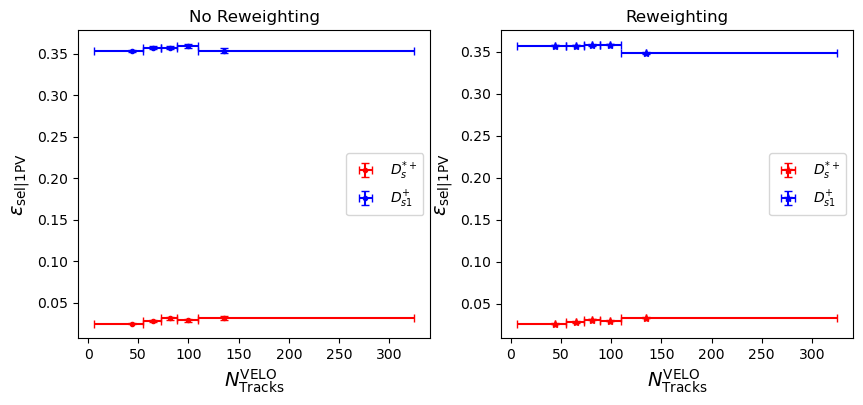

In [21]:
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.errorbar(nVelo_inter_means, eff_sel_Dsst_nMR, ueff_sel_Dsst_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='red', ecolor='red', capsize=3, label=r"$D_{s}^{*+}$")
plt.errorbar(nVelo_inter_means, eff_sel_Ds1_nMR, ueff_sel_Ds1_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='blue', ecolor='blue', capsize=3, label=r"$D_{s1}^{+}$")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\varepsilon_{\mathrm{sel}|\mathrm{1PV}}$", fontsize=14)
plt.legend()
plt.title("No Reweighting")

plt.subplot(1, 2, 2)
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\varepsilon_{\mathrm{sel}|\mathrm{1PV}}$", fontsize=14)
plt.errorbar(nVelo_inter_means, eff_sel_Dsst_MR, ueff_sel_Dsst_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='*', color='red', ecolor='red', capsize=3, label=r"$D_{s}^{*+}$")
plt.errorbar(nVelo_inter_means, eff_sel_Ds1_MR, ueff_sel_Ds1_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='*', color='blue', ecolor='blue', capsize=3, label=r"$D_{s1}^{+}$")
plt.legend()
plt.title("Reweighting")
plt.savefig("Graphs/MC_Comp_DsgL_sel_eff_1PV.pdf", dpi=300, bbox_inches='tight')

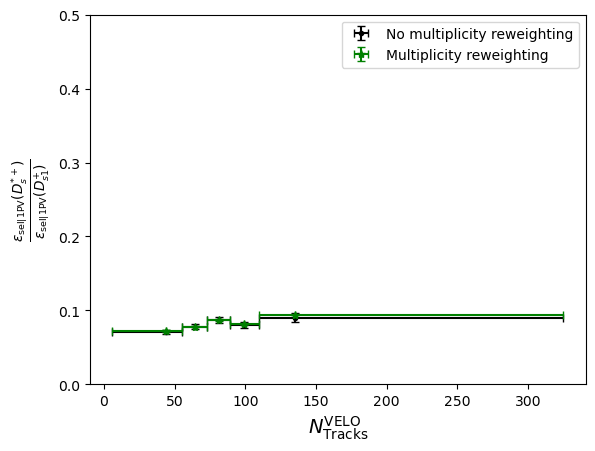

In [22]:
eff_sel_ratio_nMR = eff_sel_Dsst_nMR / eff_sel_Ds1_nMR
ueff_sel_ratio_nMR = eff_sel_ratio_nMR * np.sqrt((ueff_sel_Dsst_nMR/eff_sel_Dsst_nMR)**2+(ueff_sel_Ds1_nMR/eff_sel_Ds1_nMR)**2)

eff_sel_ratio_MR = eff_sel_Dsst_MR / eff_sel_Ds1_MR
ueff_sel_ratio_MR = eff_sel_ratio_MR * np.sqrt((ueff_sel_Dsst_MR/eff_sel_Dsst_MR)**2+(ueff_sel_Ds1_MR/eff_sel_Ds1_MR)**2)

plt.figure(2)
plt.errorbar(nVelo_inter_means, eff_sel_ratio_nMR, ueff_sel_ratio_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], 
             fmt='.', color='black', ecolor='black', capsize=3, label="No multiplicity reweighting")
plt.errorbar(nVelo_inter_means, eff_sel_ratio_MR, ueff_sel_ratio_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], 
             fmt='*', color='green', ecolor='green', capsize=3, label="Multiplicity reweighting")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\frac{\varepsilon_{\mathrm{sel}|\mathrm{1PV}}(D_s^{*+})}{\varepsilon_{\mathrm{sel}|\mathrm{1PV}}(D_{s1}^{+})}$", fontsize=14)
plt.legend()
plt.ylim(0, 0.5)
plt.savefig("Graphs/MC_Comp_DsgL_sel_eff_1PV_ratio.pdf", dpi=300, bbox_inches='tight')

###  $\varepsilon_{\mathrm{1 PV}|\mathrm{Strip}} = \frac{N_S(\mathrm{Strip} \cap \mathrm{1 PV})}{N_S(\mathrm{Strip})}$ 

## $\mathrm{N_{Tracks}^{VELO}}$ intervals

In [23]:
tdf_Dsst_sig_Velo_cuts = [tdf_Dsst_sig.Filter(x) for x in nVelo_cuts]
tdf_Ds1_sig_Velo_cuts  = [tdf_Ds1_sig.Filter(x) for x in nVelo_cuts]

### No Multiplicity Reweighting

In [24]:
hist_nVt_Dsst_sig_Velo_cuts_nMR = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Dsst_sig_Velo_cuts, nVelo_intervals)]
hist_nVt_Ds1_sig_Velo_cuts_nMR  = [x.Histo1D(("","", 100, y[0], y[1]), "nVeloTracks") for x,y in zip(tdf_Ds1_sig_Velo_cuts, nVelo_intervals)]

In [25]:
def ubinomial(eff, N):
    error = np.sqrt(eff*(1-eff)/N)
    return error

eff_1PV_Dsst_nMR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Dsst_sig_1PV_Velo_cuts_nMR, hist_nVt_Dsst_sig_Velo_cuts_nMR)])
ueff_1PV_Dsst_nMR = ubinomial(eff_sel_Dsst_nMR, np.array([x.Integral() for x in hist_nVt_Dsst_sig_Velo_cuts_nMR]))

eff_1PV_Ds1_nMR = np.array([x.Integral()/y.Integral() for x,y in zip(hist_nVt_Ds1_sig_1PV_Velo_cuts_nMR, hist_nVt_Ds1_sig_Velo_cuts_nMR)])
ueff_1PV_Ds1_nMR = ubinomial(eff_sel_Ds1_nMR, np.array([x.Integral() for x in hist_nVt_Ds1_sig_Velo_cuts_nMR]))

nVelo_inter_means = np.array([x.GetMean() for x in hist_nVt_Ds1_sig_sel_Velo_cuts_nMR])
nVelo_inter_min = np.array([x[0] for x in nVelo_intervals])
nVelo_inter_max = np.array([x[1] for x in nVelo_intervals])

nVelo_inter_uleft = nVelo_inter_means - nVelo_inter_min
nVelo_inter_uright = nVelo_inter_max - nVelo_inter_means

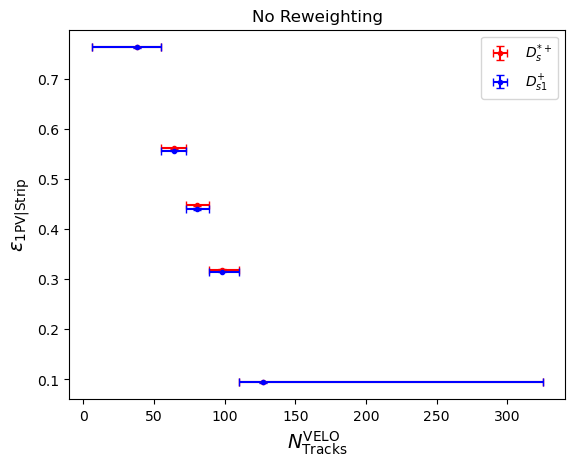

In [26]:
plt.figure(1)
plt.errorbar(nVelo_inter_means, eff_1PV_Dsst_nMR, ueff_1PV_Dsst_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='red', ecolor='red', capsize=3, label=r"$D_{s}^{*+}$")
plt.errorbar(nVelo_inter_means, eff_1PV_Ds1_nMR, ueff_1PV_Ds1_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='blue', ecolor='blue', capsize=3, label=r"$D_{s1}^{+}$")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\varepsilon_{\mathrm{1PV}|\mathrm{Strip}}$", fontsize=14)
plt.legend()
plt.title("No Reweighting")
plt.savefig("Graphs/MC_Comp_DsgL_1PV_eff_strip.pdf", dpi=300, bbox_inches='tight')

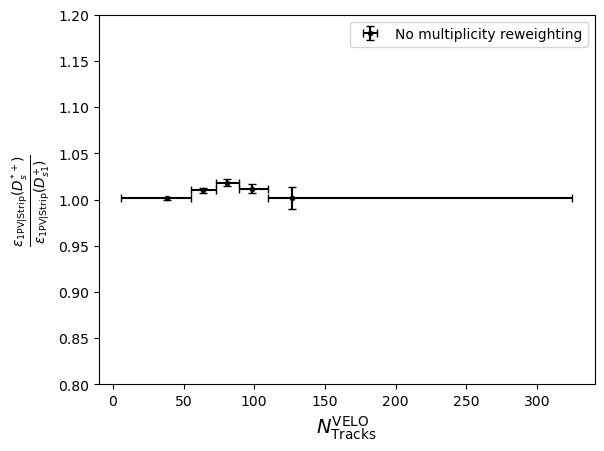

In [27]:
eff_1PV_ratio_nMR = eff_1PV_Dsst_nMR / eff_1PV_Ds1_nMR
ueff_1PV_ratio_nMR = eff_1PV_ratio_nMR * np.sqrt((ueff_1PV_Dsst_nMR/eff_1PV_Dsst_nMR)**2+(ueff_1PV_Ds1_nMR/eff_1PV_Ds1_nMR)**2)

plt.figure(2)
plt.errorbar(nVelo_inter_means, eff_1PV_ratio_nMR, ueff_1PV_ratio_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], 
             fmt='.', color='black', ecolor='black', capsize=3, label="No multiplicity reweighting")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\frac{\varepsilon_{\mathrm{1PV}|\mathrm{Strip}}(D_s^{*+})}{\varepsilon_{\mathrm{1PV}|\mathrm{Strip}}(D_{s1}^{+})}$", fontsize=14)
plt.legend()
plt.ylim(0.8, 1.2)
plt.savefig("Graphs/MC_Comp_DsgL_1PV_eff_strip_ratio.pdf", dpi=300, bbox_inches='tight')

### Efficiency Product

In [28]:
eff_sel_tot_Dsst_nMR = eff_1PV_Dsst_nMR * eff_sel_Dsst_nMR
ueff_sel_tot_Dsst_nMR = eff_sel_tot_Dsst_nMR * np.sqrt((ueff_1PV_Dsst_nMR/eff_1PV_Dsst_nMR)**2+(ueff_sel_Dsst_nMR/eff_sel_Dsst_MR)**2)

eff_sel_tot_Ds1_nMR = eff_1PV_Ds1_nMR * eff_sel_Ds1_nMR
ueff_sel_tot_Ds1_nMR = eff_sel_tot_Ds1_nMR * np.sqrt((ueff_1PV_Ds1_nMR/eff_1PV_Dsst_nMR)**2+(ueff_sel_Ds1_nMR/eff_sel_Ds1_MR)**2)

eff_sel_tot_Dsst_MR = eff_1PV_Dsst_nMR * eff_sel_Dsst_MR
ueff_sel_tot_Dsst_MR = eff_sel_tot_Dsst_MR * np.sqrt((ueff_1PV_Dsst_nMR/eff_1PV_Dsst_nMR)**2+(ueff_sel_Dsst_MR/eff_sel_Dsst_MR)**2)

eff_sel_tot_Ds1_MR = eff_1PV_Ds1_nMR * eff_sel_Ds1_MR
ueff_sel_tot_Ds1_MR = eff_sel_tot_Ds1_MR * np.sqrt((ueff_1PV_Ds1_nMR/eff_1PV_Dsst_nMR)**2+(ueff_sel_Ds1_MR/eff_sel_Ds1_MR)**2)

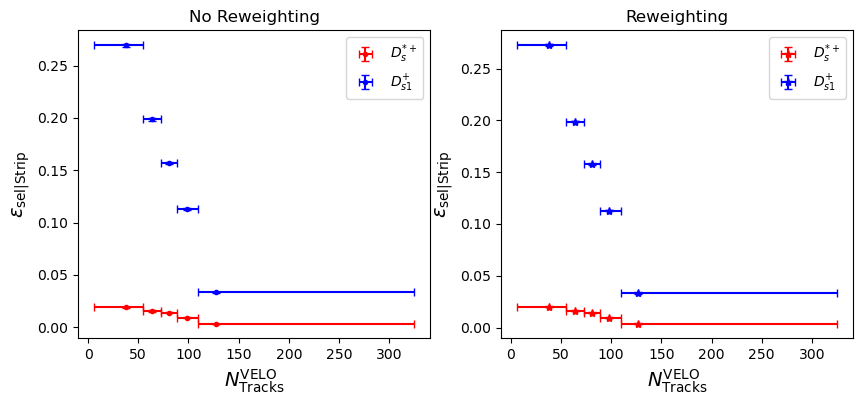

In [29]:
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.errorbar(nVelo_inter_means, eff_sel_tot_Dsst_nMR, ueff_sel_tot_Dsst_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='red', ecolor='red', capsize=3, label=r"$D_{s}^{*+}$")
plt.errorbar(nVelo_inter_means, eff_sel_tot_Ds1_nMR, ueff_sel_tot_Ds1_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='.', color='blue', ecolor='blue', capsize=3, label=r"$D_{s1}^{+}$")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\varepsilon_{\mathrm{sel}|\mathrm{Strip}}$", fontsize=14)
plt.legend()
plt.title("No Reweighting")

plt.subplot(1, 2, 2)
plt.errorbar(nVelo_inter_means, eff_sel_tot_Dsst_MR, ueff_sel_tot_Dsst_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='*', color='red', ecolor='red', capsize=3, label=r"$D_{s}^{*+}$")
plt.errorbar(nVelo_inter_means, eff_sel_tot_Ds1_MR, ueff_sel_tot_Ds1_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], fmt='*', color='blue', ecolor='blue', capsize=3, label=r"$D_{s1}^{+}$")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\varepsilon_{\mathrm{sel}|\mathrm{Strip}}$", fontsize=14)
plt.legend()
plt.title("Reweighting")
plt.savefig("Graphs/MC_Comp_DsgL_sel_eff.pdf", dpi=300, bbox_inches='tight')

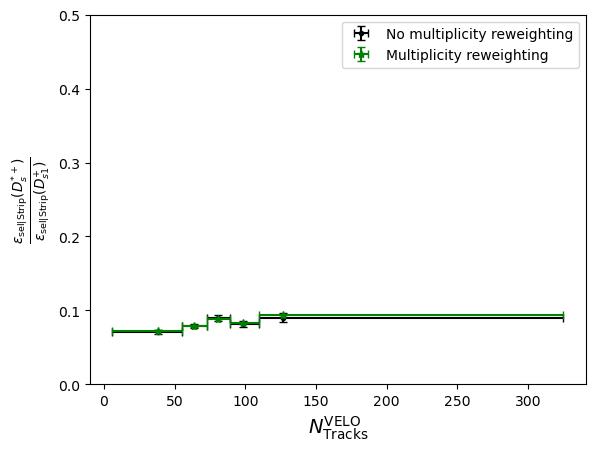

In [30]:
eff_sel_tot_ratio_nMR = eff_sel_tot_Dsst_nMR / eff_sel_tot_Ds1_nMR
ueff_sel_tot_ratio_nMR = eff_sel_tot_ratio_nMR * np.sqrt((ueff_sel_tot_Dsst_nMR/eff_sel_tot_Dsst_nMR)**2+(ueff_sel_tot_Ds1_nMR/eff_sel_tot_Ds1_nMR)**2)

eff_sel_tot_ratio_MR = eff_sel_tot_Dsst_MR / eff_sel_tot_Ds1_MR
ueff_sel_tot_ratio_MR = eff_sel_tot_ratio_MR * np.sqrt((ueff_sel_tot_Dsst_MR/eff_sel_tot_Dsst_MR)**2+(ueff_sel_tot_Ds1_MR/eff_sel_tot_Ds1_MR)**2)

plt.figure(2)
plt.errorbar(nVelo_inter_means, eff_sel_tot_ratio_nMR, ueff_sel_ratio_nMR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], 
             fmt='.', color='black', ecolor='black', capsize=3, label="No multiplicity reweighting")
plt.errorbar(nVelo_inter_means, eff_sel_tot_ratio_MR, ueff_sel_ratio_MR, xerr=[nVelo_inter_uleft, nVelo_inter_uright], 
             fmt='*', color='green', ecolor='green', capsize=3, label="Multiplicity reweighting")
plt.xlabel(r"$N^{\mathrm{VELO}}_{\mathrm{Tracks}}$", fontsize=14)
plt.ylabel(r"$\frac{\varepsilon_{\mathrm{sel}|\mathrm{Strip}}(D_s^{*+})}{\varepsilon_{\mathrm{sel}|\mathrm{Strip}}(D_{s1}^{+})}$", fontsize=14)
plt.legend()
plt.ylim(0, 0.5)
plt.savefig("Graphs/MC_Comp_DsgL_sel_eff_ratio.pdf", dpi=300, bbox_inches='tight')